# Predicting the Energy Consumption in NL

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet.forecaster import Prophet
import seaborn as sns
sns.set()
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.style.use('seaborn')

# Import Data
raw_data = pd.read_excel('NL_energy_cons_06_15_MW.xlsx')

# Selecting the columns in raw data
raw_data = raw_data[['year','month','day','hour','act_cons']]

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Text(0.5, 0.98, 'Yearly, Monthly and Daily Energy Consuption trend in the NL 2006-2015')

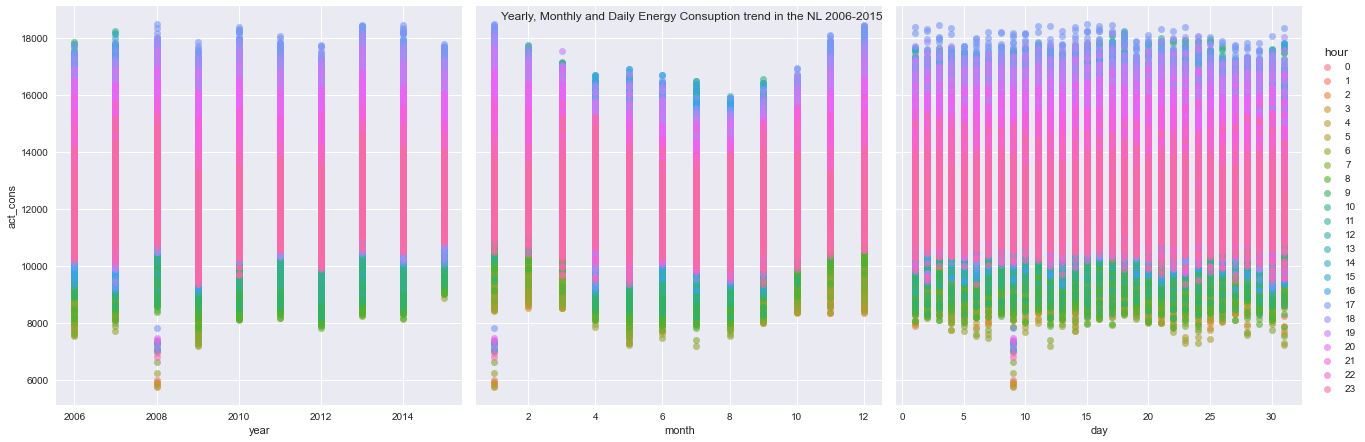

In [55]:
sns.pairplot(x_vars = ['year','month','day'], 
             y_vars = ['act_cons'], 
             data   = raw_data,
             markers = "o",
             hue    = 'hour',
             diag_kind = 'kde',
             height = 6,
             plot_kws = {'alpha': 0.6, 'linewidth':0});
plt.suptitle('Yearly, Monthly and Daily Energy Consuption trend in the NL 2006-2015', 
             size = 12)

Text(0.5, 0.98, 'Yearly, Monthly and Daily Energy Consuption trend in the NL 2006-2015')

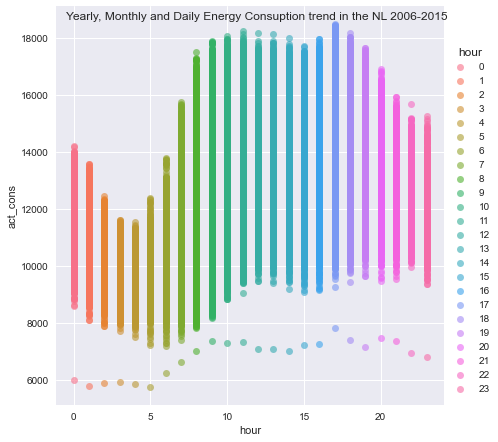

In [54]:
sns.pairplot(x_vars = ['hour'], 
             y_vars = ['act_cons'], 
             data   = raw_data,
             markers = "o",
             hue    = 'hour',
             diag_kind = 'kde',
             height = 6,
             plot_kws = {'alpha': 0.6, 'linewidth':0});
plt.suptitle('Hourly Energy Consuption trend in the NL 2006-2015', 
             size = 12)

In [40]:
# Data Cleaning 

# Identify NULL values
raw_data.loc[raw_data.act_cons < 7000]

# Replacing NULL values
raw_data.loc[1416].act_cons = 9931
raw_data.loc[2160].act_cons = 10225

,year,month,day,hour,act_cons
1416,2006,3,1,0,0
2160,2006,4,1,0,0


In [60]:
# Converting columns to datetime 
raw_data_datetime = raw_data.copy()
raw_data_datetime['datetime']= pd.to_datetime(raw_data_datetime[['year','month','day','hour']])
raw_data_datetime_only = raw_data_datetime[['datetime','act_cons']]
raw_data_datetime_only = raw_data_datetime_only.rename(columns={'datetime':'ds','act_cons':'y'})

In [69]:
# Train Test Split

# Specify the Split date
split_date = '2012-08-01 01:00:00'

# Identify the location of split date
raw_data_datetime_only.loc[raw_data_datetime_only['ds']==pd.to_datetime(split_date)]

# Splitting the data into train test
train_data_prophet = raw_data_datetime_only.loc[raw_data_datetime_only.index < 57587]
test_data_prophet = raw_data_datetime_only.loc[raw_data_datetime_only.index >= 57587]

In [62]:
# Setup Model
model = Prophet(growth='linear',
                seasonality_mode='additive',
                seasonality_prior_scale= 15
               ).add_seasonality(
                    name ='quarterly',
                    period =365.25/4,
                    fourier_order= 20)
# Fitting the model
model.fit(train_data_prophet)

# Prdicting on the test data
model_predict = model.predict(test_data_prophet)

In [70]:
# Calculating Errors
# Actual MW consumption
y_test = test_data_prophet['y']

# Predicted MW consumption
y_pred = model_predict['yhat']

# Mean Squared Error 3449198
mse = mean_squared_error(y_test, y_pred)

# Mean Absolute Error 1635.3692670292073
mae = mean_absolute_error(y_test, y_pred)

# Mean Absolute Percentage Error 12.64
mape = np.mean(np.abs((np.array(y_test)-np.array(y_pred))/np.array(y_test)))*100

# Adding Prediction data to 'test_data_prophet' (Test Dataframe) and resetting the index
test_data_prophet = test_data_prophet.reset_index()
test_data_prophet['preds'] = model_predict['yhat'].copy()

# Calculating Absolute error
test_data_prophet['error']= (test_data_prophet['y']-test_data_prophet['preds']).apply(np.abs)

# Sort Error to find the Worst and Best predictions
test_data_prophet.sort_values('error', ascending=True).tail(10)

,index,ds,y,preds,error
25546,83133,2015-07-05 03:00:00,10267,6213.980404,4053.019596
26050,83637,2015-07-26 03:00:00,9411,5353.301994,4057.698006
28023,85610,2015-10-16 08:00:00,15689,11620.347366,4068.652634
26387,83974,2015-08-09 04:00:00,9261,5180.365229,4080.634771
26051,83638,2015-07-26 04:00:00,9317,5232.169320,4084.830680
21229,78816,2015-01-05 08:00:00,16232,12130.577085,4101.422915
26554,84141,2015-08-16 03:00:00,9662,5541.925332,4120.074668
26555,84142,2015-08-16 04:00:00,9559,5417.696694,4141.303306
26218,83805,2015-08-02 03:00:00,9282,5064.745860,4217.254140
26219,83806,2015-08-02 04:00:00,9193,4947.387509,4245.612491


In [71]:
mae

1299.7636835998178

In [72]:
mape

10.070450469737287

In [73]:
mse

2348471.1696791784

(0.0, 20000.0)

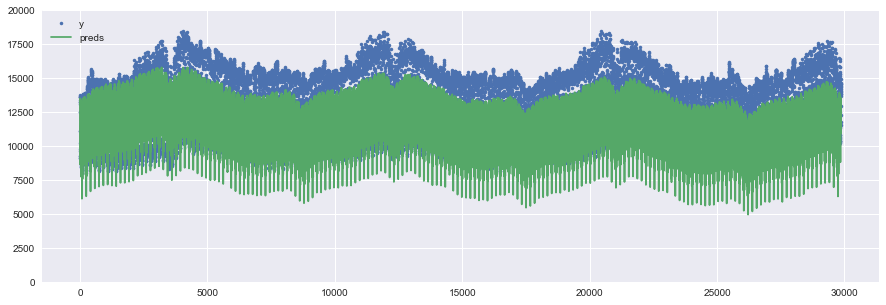

In [78]:
# Plotting the Best Predictions

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_=test_data_prophet[['y','preds']].plot(ax=ax, style=['.'])
#ax.set_xbound(lower=12270, upper=12500)
ax.set_ylim(0, 20000)

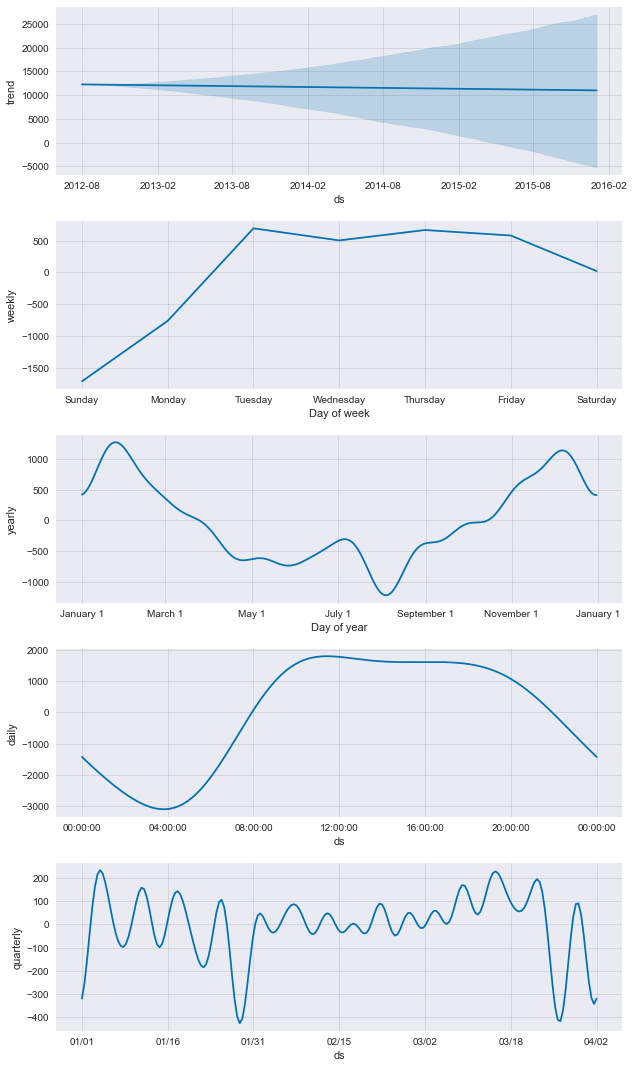

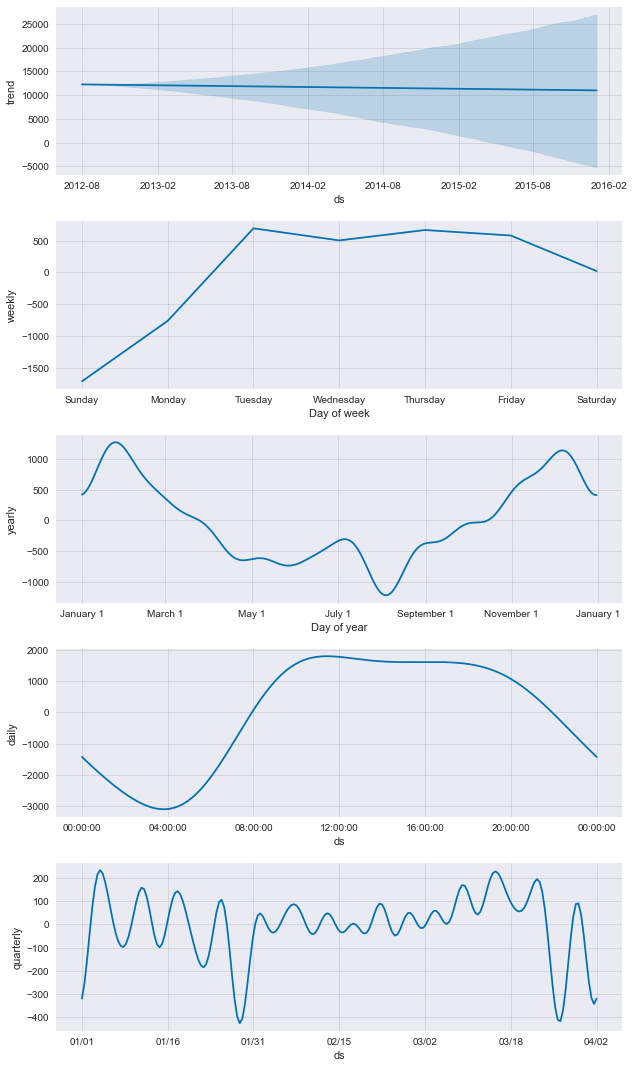

In [79]:
model.plot_components(model_predict)